In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import k0 as K0, k1 as K1, exp1
from scipy.signal import lfilter
from itertools import cycle

import wellfunctionalities as wf
import fdm3Blom
from fdm.mfgrid import Grid
from importlib import reload

# Reikwijdte stationair semi-spanningswater

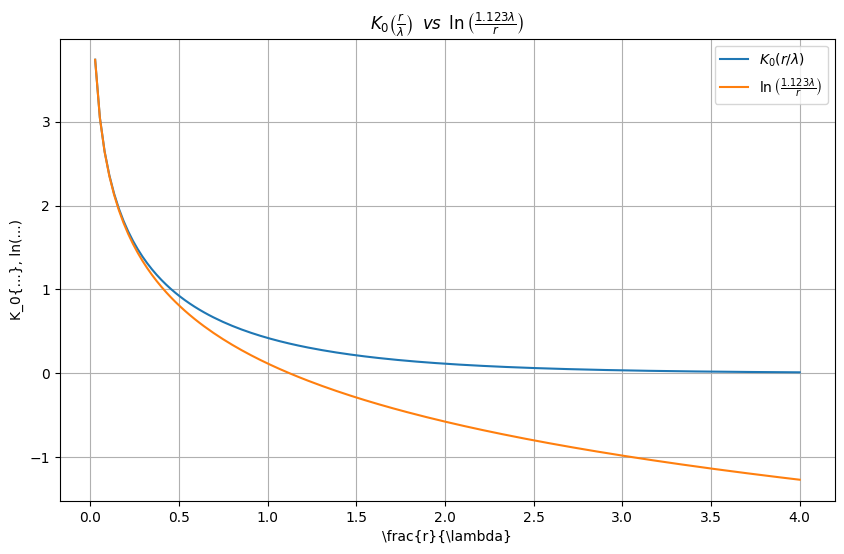

In [10]:
rho = np.linspace(0, 4, 151)[1:]

title=r"$K_0 \left(\frac{r}{\lambda} \right)\,\,\,vs\,\,\,\ln \left(\frac{1.123 \lambda}{r} \right)$"

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel=r"\frac{r}{\lambda}", ylabel="K_0{...}, ln(...)")
ax.plot(rho, K0(rho), label=r'$K_0(r/\lambda)$')
ax.plot(rho, np.log(1.123 /rho), label=r'$\ln \left(\frac{1.123 \lambda}{r} \right)$')
ax.grid()
ax.legend()

# Hantush, verdeling langs een lijnonttrekking


$$ y = \exp \left(a \frac {\left(\frac x L\right)^2} {1 - \left(\frac x L\right)^2}\right) $$


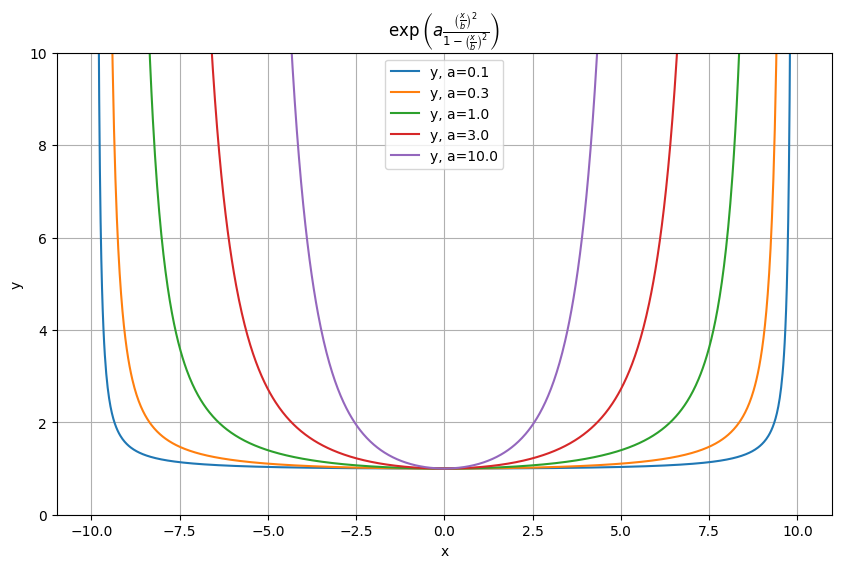

In [51]:
b = 10.
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=r"$\exp\left(a \frac{\left(\frac{x}{b}\right)^2}{1 - \left(\frac{x}{b}\right)^2}\right)$", xlabel='x', ylabel="y")
x = np.linspace(-b, b, 1001)[1:-1]
for a in [0.1, 0.3, 1., 3., 10.]:
    rho = x / b
    y = np.exp(np.clip(a * (rho ** 2 / (1 - rho ** 2)), -50, 50))
    ax.plot(x, y, label=f"y, a={a}")    
ax.grid()
ax.set_ylim(0, 10)
ax.legend()

# Optimalisatie van de onttrekking van de putten langs een lijnbron.

/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_39984/1045823090.py:27: RuntimeWarning: divide by zero encountered in divide
  return np.exp(np.clip(a * (rho ** 2 / (1 - rho ** 2)), -50, 50))


Geoptimaliseerde waarde voor a: 0.5


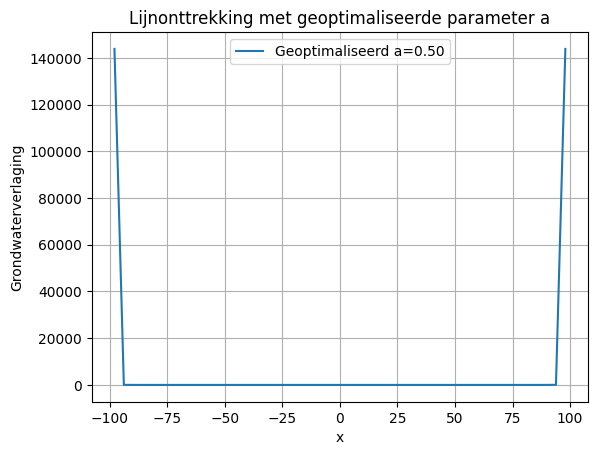

In [ ]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Gegeven parameters
kD, S, Q = 600., 0.2, -1200.
t = 1.
b = 100. # halve lengte van de lijnonttrekking

xw = np.linspace(-b, b, 50)  # Meetpunten langs de lijnonttrekking
yw = np.zeros_like(xw)
xm = 0.5 * (xw[:-1] + xw[1:])
ym = np.zeros_like(xm)

a_ideal = 1  # Gewenste waarde voor de stijghoogte
r = np.sqrt((xm[:, None] - xw[None, :]) ** 2 +(ym[:, None] - yw[None, :]) ** 2)

def ddn(Q):    
    u = r ** 2 * S / (4 * kD * t)
    s = Q / (4 * np.pi * kD) * exp1(u)
    return np.sum(s, axis=-1)


# Puntonttrekkingsoplossing (voorbeeld: e^ (a * (x^2 / (L^2 - x^2))))
def point_withdrawal(x, a):    
    rho = x / b
    return np.exp(np.clip(a * (rho ** 2 / (1 - rho ** 2)), -50, 50))

# Functie om de fout te berekenen
def objective(a, xw, a_ideal):
    # Bereken de gemodelleerde stijghoogte
    fac = point_withdrawal(xw, a)
    s = ddn(Q * fac)
    
    # Fout: verschil tussen gemodelleerde en ideale waarde
    error = np.sum((s - a_ideal)**2)  # Kleinste kwadraten
    return error

# Optimalisatie uitvoeren
result = opt.minimize(objective, x0=[0.5], args=(xw, a_ideal))

# Geoptimaliseerde waarde van a
a_optimal = result.x[0]
print(f"Geoptimaliseerde waarde voor a: {a_optimal}")

# Plotten van de resultaten
y_values_optimal = point_withdrawal(xm, a_optimal)
plt.plot(xm, y_values_optimal, label=f"Geoptimaliseerd a={a_optimal:.2f}")
plt.xlabel('x')
plt.ylabel('Grondwaterverlaging')
plt.title('Lijnonttrekking met geoptimaliseerde parameter a')
plt.grid(True)
plt.legend()
plt.show()


# Testen van de verdeling van de onttrekking over een lijnbron

/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_39984/1605887473.py:17: RuntimeWarning: divide by zero encountered in divide
  return np.exp(np.clip(a * (rho ** 2 / (1 - rho ** 2)), -50, 50))


ValueError: operands could not be broadcast together with shapes (50,1) (49,50) 

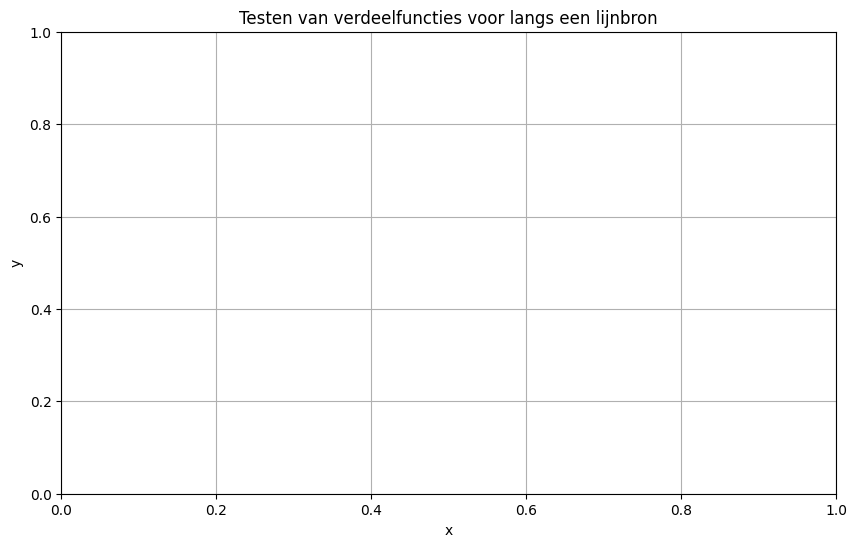

In [59]:
# Gegeven parameters
kD, S, Q = 600., 0.2, -1200.
t = 1.
b = 100. # halve lengte van de lijnonttrekking
a = 1.

xw = np.linspace(-b, b, 50)  # Meetpunten langs de lijnonttrekking
yw = np.zeros_like(xw)
xm = 0.5 * (xw[:-1] + xw[1:])
ym = np.zeros_like(xm)

a_ideal = 1  # Gewenste waarde voor de stijghoogte
r = np.sqrt((xm[:, None] - xw[None, :]) ** 2 +(ym[:, None] - yw[None, :]) ** 2)

def verdeel(x, a):    
    rho = x / b
    return np.exp(np.clip(a * (rho ** 2 / (1 - rho ** 2)), -50, 50))

def ddn(Q):    
    u = r ** 2 * S / (4 * kD * t)
    s = (verdeel(xw, a) * Q)[:, None] / (4 * np.pi * kD) * exp1(u)
    return np.sum(s, axis=-1)

fig, ax = plt.subplots(figsize=(10,6))
ax.set(title="Testen van verdeelfuncties voor langs een lijnbron", xlabel="x", ylabel="y")
ax.grid()
ax.plot(xm, ddn(Q), label="Verdeelfunctie")
ax.legend()